In [ ]:
import warnings
warnings.filterwarnings('ignore')
import sys
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from keras import backend as K
from keras.models import load_model
import tensorflow as tf

# Load Models

In [2]:
n_z = 32
def vae_loss(y_true, y_pred):
    
    # Reconstruction Loss
    y_true_reshaped=tf.reshape(y_true,[-1,89,11])
    recon = 10 * K.mean(K.sum(K.categorical_crossentropy(y_true_reshaped, y_pred, axis=2),axis=1))

    # KL Divergence Loss
    kl = 0.05 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)
    
    #Total loss
    return recon + kl

In [5]:
cvae_decoder = load_model('../CVAE/ding_decoder_best.h5',custom_objects={'n_z': n_z,'vae_loss':vae_loss})
vae_decoder = load_model('../VAE/vae_decoder_best.h5',custom_objects={'n_z': n_z,'vae_loss':vae_loss})

In [6]:
def sample_z_batch(batch_size):
    return K.random_normal(shape=(batch_size, n_z), mean=0., stddev=1.)

In [ ]:
pred_delta_e = load_model('../Predictors/delta_e_best_model.h5')
pred_energy_pa = load_model('../Predictors/energy_pa_best_model.h5')
pred_volume_pa =load_model('../Predictors/volume_pa_best_model.h5')

# Distribution of Properties of generated molecules

## Function to generate n unique molecules from the models 

In [8]:
element_list = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr','Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu']
def generate_unique(desired, num, decoder, model='cvae'):
    init_generate = 10 * num
    property_desired = desired
    prop_generated = []
    latent_vectors = K.eval(sample_z_batch(init_generate))
    if model == 'cvae':
        mols_encodings = decoder.predict([latent_vectors,np.tile(property_desired,(init_generate,1))])
    else:
        mols_encodings = decoder.predict(latent_vectors)

    mols_encodings[mols_encodings<0.5]=0
    generated_molecules = set()
    for idx in range(init_generate):
        output_gen=np.zeros((89,))
        for j,atom in enumerate(mols_encodings[idx,:]):
            if atom.max()!=0:
                output_gen[j] = atom.argmax() 
    
        element_dict = {}
        for i in range(output_gen.size):
            if output_gen[i]:
                element_dict[element_list[i]] = output_gen[i]
        mol_string = ""
        for elem in sorted(element_dict):
            mol_string += str(elem) + str(int(element_dict[elem]))     
            
        if(mol_string not in generated_molecules and mol_string is not ""):
            delta_e=pred_delta_e.predict(mols_encodings[idx,:].reshape(1,-1)).flatten()[0]
            volume_pa=pred_volume_pa.predict(mols_encodings[idx,:].reshape(1,-1)).flatten()[0]
            energy_pa=pred_energy_pa.predict(mols_encodings[idx,:].reshape(1,-1)).flatten()[0]
            current_properties=np.array([delta_e,volume_pa,energy_pa])
            prop_generated.append(current_properties)
            generated_molecules.add(mol_string)
            
        sys.stdout.write('\r {} {}'.format(len(generated_molecules),idx))
        if len(generated_molecules)>=1000:
            break

    return np.array(prop_generated), generated_molecules

In [11]:
prop_desired = [-2, 12, -6.5]
prop_generated_cvae, mols_cvae = generate_unique(prop_desired, 1000, cvae_decoder)
print()
prop_generated_vae, mols_vae = generate_unique(prop_desired, 1000, vae_decoder, 'vae')

 1000 1589
 1000 1463

## Plot distributions

In [11]:
plt.rc('xtick', labelsize=60)
plt.rc('xtick.major', size=40, width=6, pad=30)
plt.rc('ytick', labelsize=40)
plt.rc('axes',linewidth=6, labelpad=30)

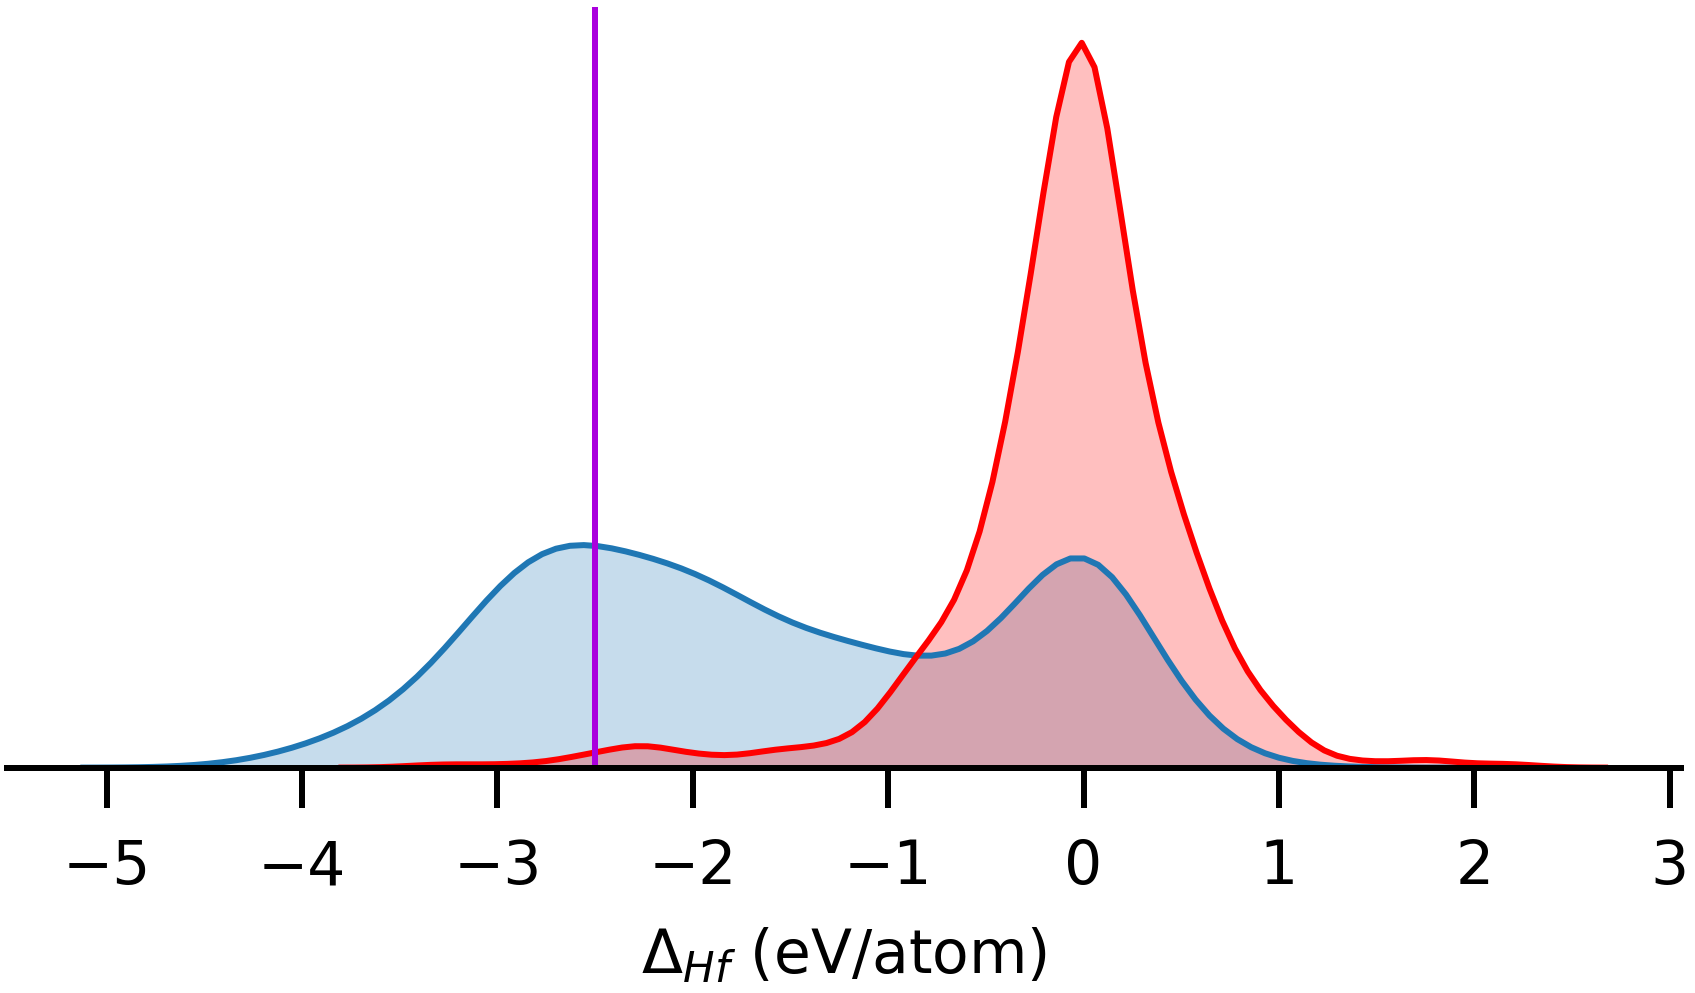

In [12]:
plt.figure(figsize=(30,14))
sns.distplot(prop_generated_cvae[:,0], hist=False, kde_kws={"shade":True, "linewidth":6}, norm_hist=True)
sns.distplot(prop_generated_vae[:,0], hist=False, kde_kws={"shade":True, "linewidth":6}, norm_hist=True, color='r')
plt.axvline(prop_desired[0],color='#aa00dd',label="Target Value", linewidth=6)
plt.xlabel(r'$\Delta_{Hf}$ (eV/atom)', fontsize=60)
ax = plt.subplot(1,1,1)
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

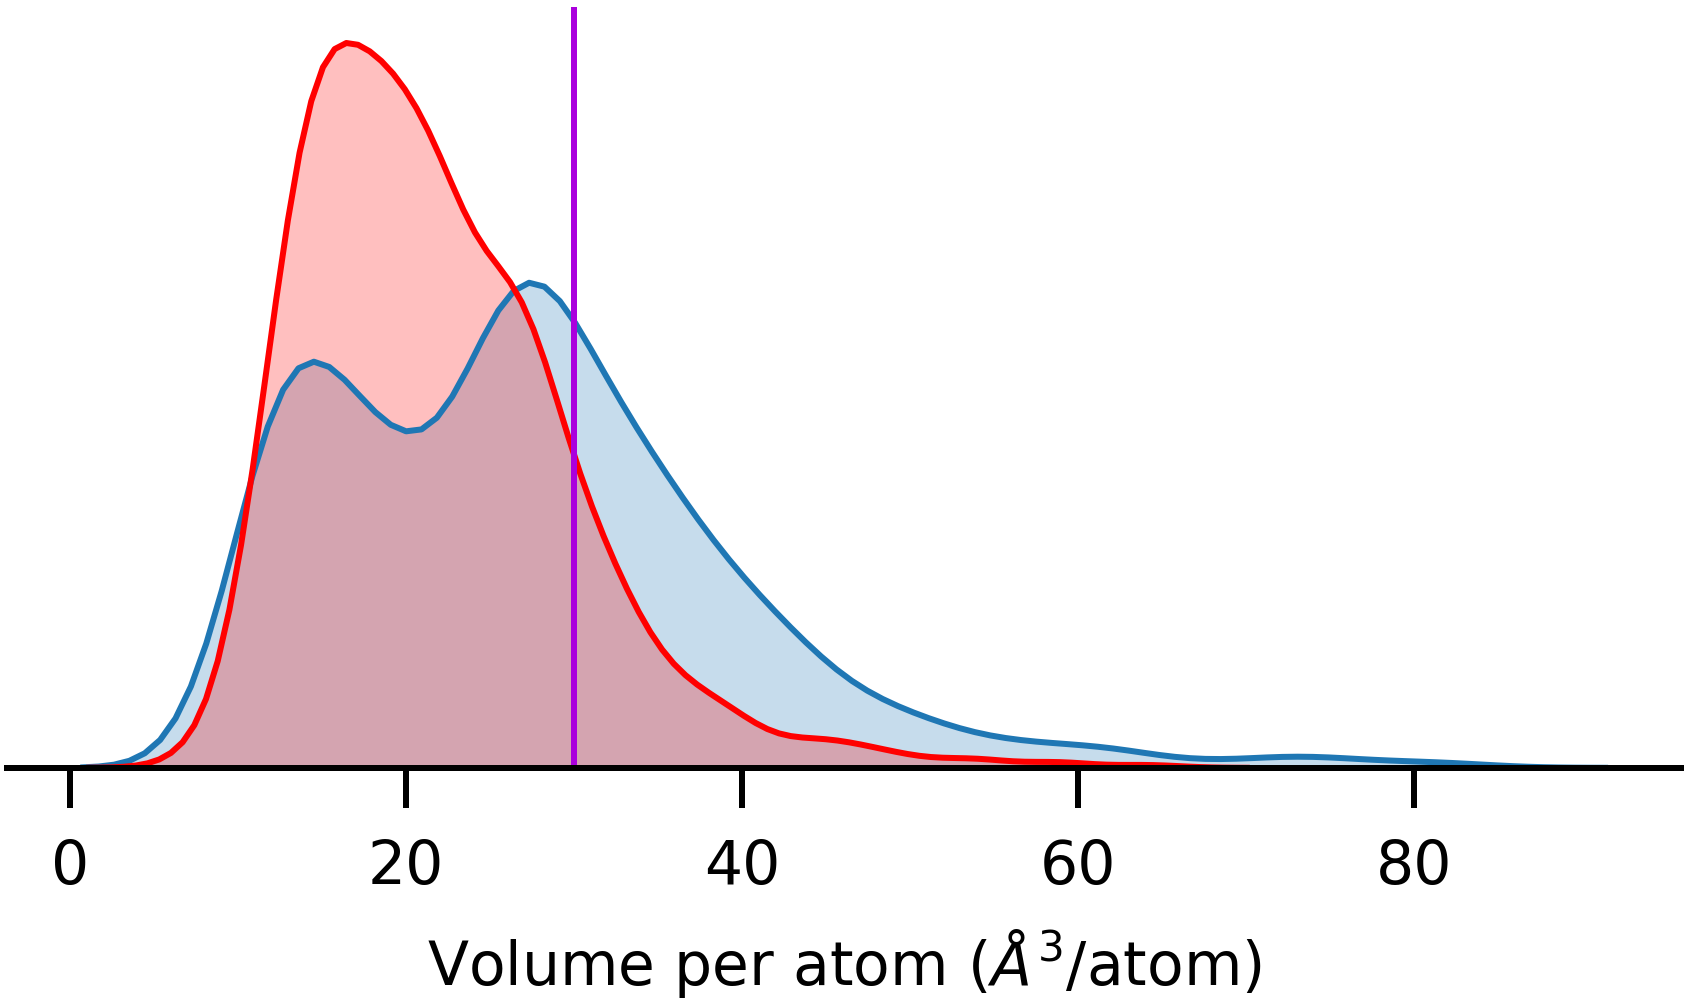

In [13]:
plt.figure(figsize=(30,14))
sns.distplot(prop_generated_cvae[:,1], hist=False, kde_kws={"shade":True, "linewidth":6}, norm_hist=True)
sns.distplot(prop_generated_vae[:,1], hist=False, kde_kws={"shade":True, "linewidth":6}, norm_hist=True, color='r')
plt.axvline(prop_desired[1],color='#aa00dd',label="Target Value", linewidth=6)
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
#           ncol=3, fancybox=True, shadow=True)
plt.xlabel(r'Volume per atom ($\AA^3$/atom)', fontsize='60')
ax = plt.subplot(1,1,1)
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

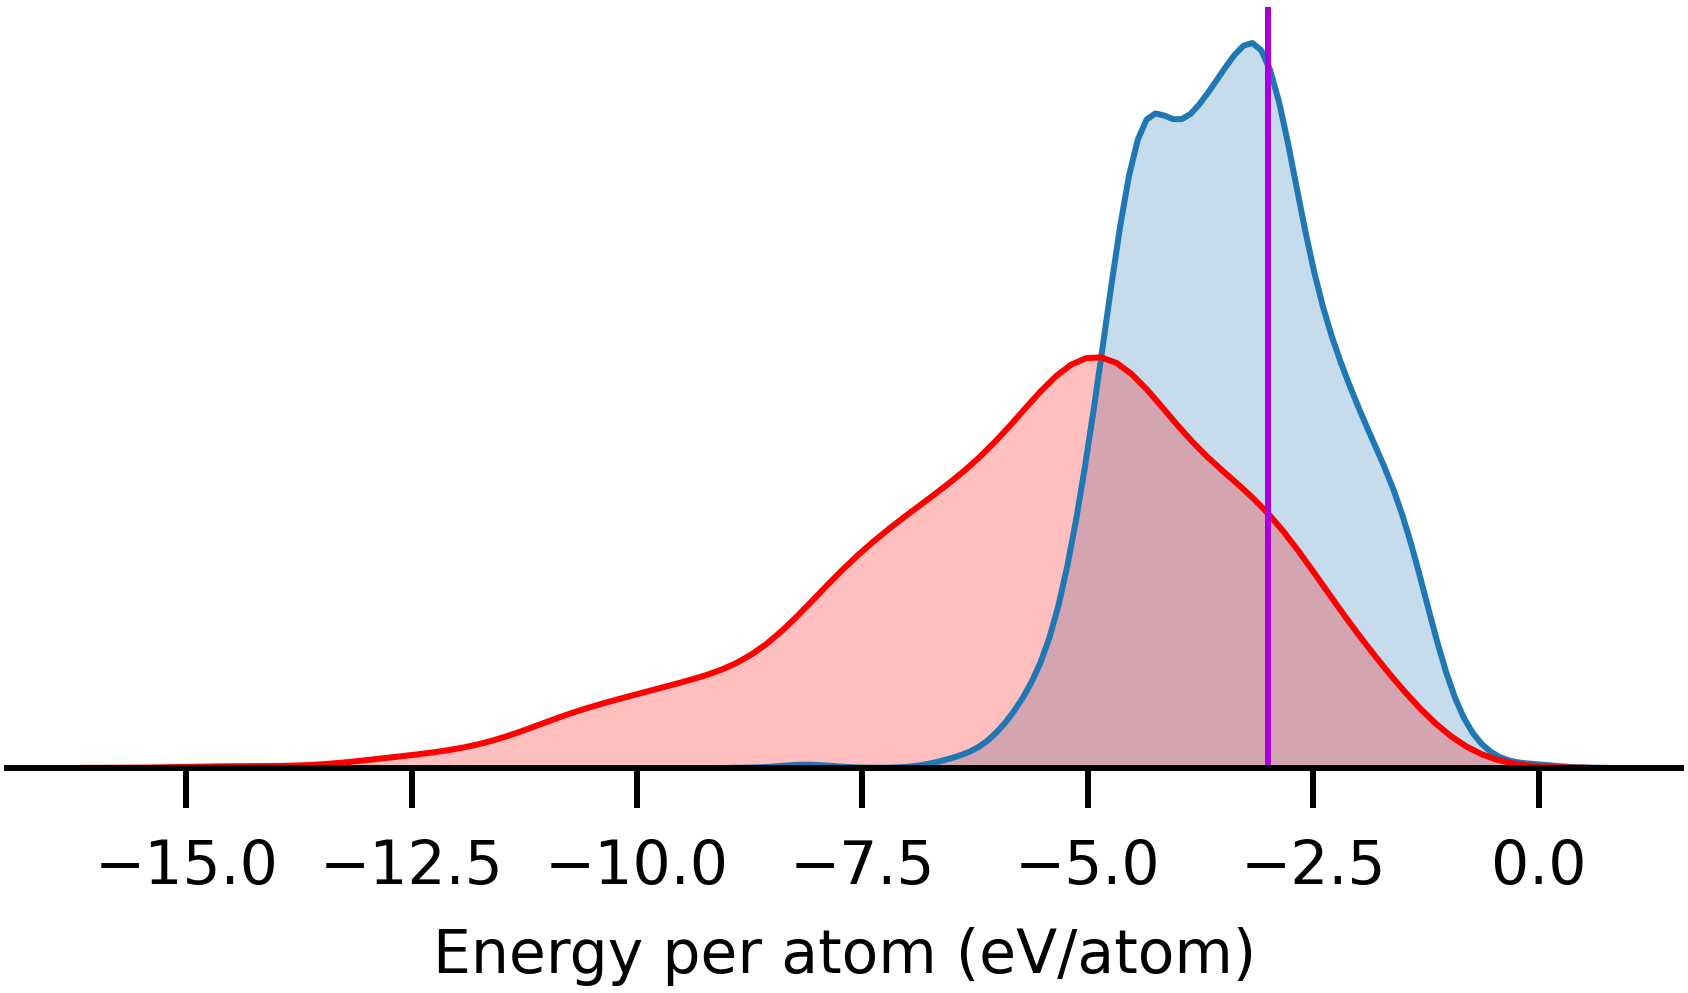

In [14]:
plt.figure(figsize=(30,14))
sns.distplot(prop_generated_cvae[:,2], hist=False, kde_kws={"shade":True, "linewidth":6}, norm_hist=True,)
sns.distplot(prop_generated_vae[:,2], hist=False, kde_kws={"shade":True, "linewidth":6}, norm_hist=True, color='r')
plt.axvline(prop_desired[2],color='#aa00dd', linewidth=6)
plt.xlabel('Energy per atom (eV/atom)', fontsize=60)
ax = plt.subplot(1,1,1)
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()


In [15]:
sav = {'molecules_cvae':mols_cvae, 'molecules_vae':mols_vae, 'desired_properties':prop_desired, 'cvae_gen_properties':prop_generated_cvae,  'vae_gen_properties':prop_generated_vae}

In [ ]:
pickle.dump(sav, open('gen_data.pkl','wb'))